# SPRINT COGNITIVE CYBERSECURITY

Integrantes:

95985 - Henrico Nardelli Bela<br>
95044 - Guilherme Antonio Silva<br>
96232 - Felype Nunes de Souza<br>
94341 - Rafael Pereira da Silva<br>

In [63]:
# Image preprocessing
from skimage.transform import resize, rescale
from skimage.feature import hog
from skimage.io import imread
from skimage.color import rgba2rgb
import skimage

# Model training | Sklearn
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Data analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt

# Other
# from google.colab import files
from collections import Counter
import joblib, os

# Data preprocessing

In [64]:
 def resize_all(src, pklname, include, width=300, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})face images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    # If image is in RGBA scale turn it into RGB
                    if im.shape[2] > 3:
                      im = rgba2rgb(im)
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir)
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [65]:
# Display sample folders
data_path = './Image'
os.listdir(data_path)

# Create dataset
base_name = 'faces'
width = 200

include = {'Fake', 'Real'}
resize_all(src=data_path, pklname=base_name, width=width, include=include)

Fake
Real


In [66]:
# Print summary
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']), '\n')
 
Counter(data['label'])

number of samples:  50
keys:  ['description', 'label', 'filename', 'data']
description:  resized (200x200)face images in rgb
image shape:  (200, 200, 3)
labels: ['Fake' 'Real'] 



Counter({'Fake': 25, 'Real': 25})

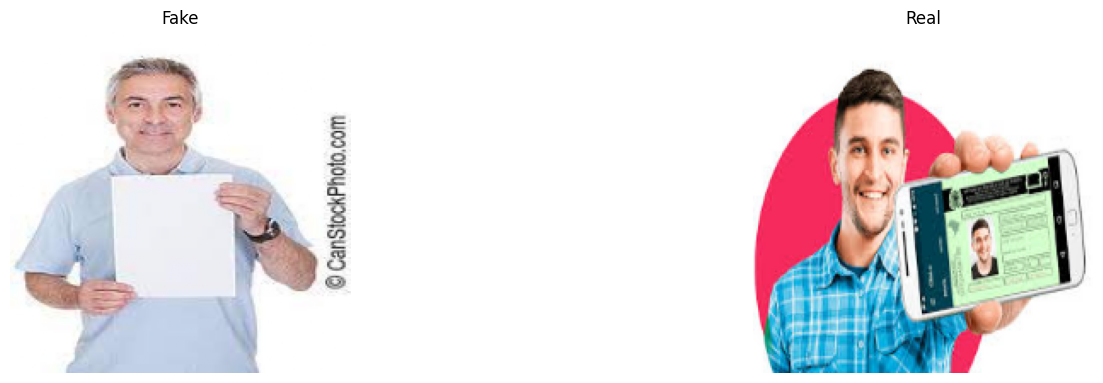

In [67]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# Make a plot for every label type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

# Model Training

In [68]:
X = np.array(data['data'])
y = np.array(data['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    shuffle=True, random_state=42)

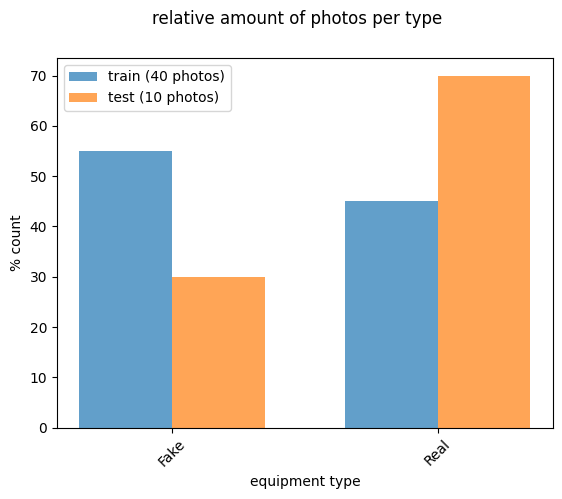

In [69]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

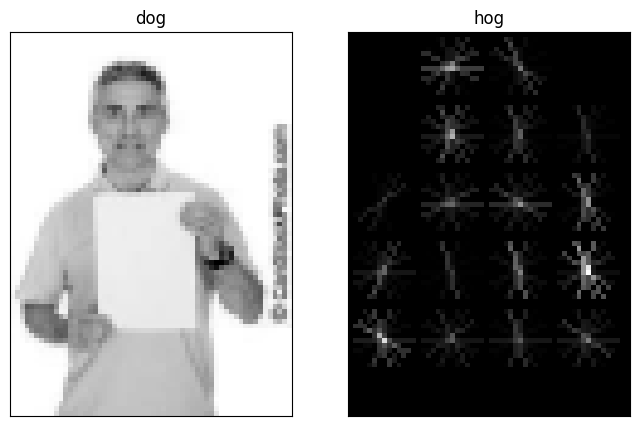

In [70]:
dog = imread('Image/Fake/1.jpg', as_gray=True)

# scale down the image to one third
dog = rescale(dog, 1/3, mode='reflect')
# calculate the hog and return a visual representation.
dog_hog, dog_hog_img = hog(
    dog, pixels_per_cell=(14,14), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(dog, cmap='gray')
ax[0].set_title('dog')
ax[1].imshow(dog_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

In [71]:
print('number of pixels: ', dog.shape[0] * dog.shape[1])
print('number of hog features: ', dog_hog.shape[0])

number of pixels:  4582
number of hog features:  432


In [72]:
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [73]:
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

# create an instance of each transformer
scalify = StandardScaler() 
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(40, 6084)
(40, 6084)


In [74]:
# Training
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

In [75]:
SGDClassifier(random_state=42)

SGDClassifier(random_state=42)

# Model Testing

In [76]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

In [77]:
y_pred = sgd_clf.predict(X_test_prepared)
print(f'Percentage correct: ', accuracy_score(y_test, y_pred))

Percentage correct:  0.5


# Evaluation Results

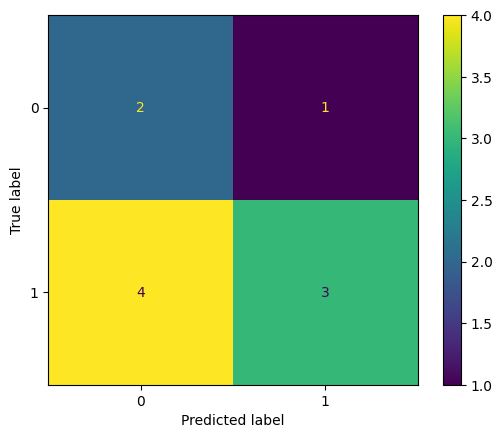

In [78]:
cmx = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cmx)
cmd.plot()

# Using model to classify a photo

In [79]:
# Save model
file_name = 'cnh_clf.joblib.pkl'
_ = joblib.dump(sgd_clf, file_name, compress=9)

In [127]:
# Load classifier
clf = joblib.load(file_name)
import streamlit as st
# Load a new photo
def classify_photo():
  uploaded = st.file_uploader()
  for fn in uploaded.keys():
    print(f'Uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

  # Open and preprocess photo 
  im = imread(fn)
  if im.shape[2] > 3:
    im = rgba2rgb(im)
  im = resize(im, (200, 200))

  joblib.dump(im, f"{fn.split('.')[0]}.pkl")
  data = joblib.load(f'{fn.split(".")[0]}.pkl')
  data = np.array(data)
  grayify = RGB2GrayTransformer()
  hogify = HogTransformer(pixels_per_cell=(14, 14), cells_per_block=(2,2), orientations=9, block_norm='L2-Hys')

  data_gray = grayify.transform([data])
  data_hog = hogify.transform(data_gray)

  prediction = clf.predict(data_hog)
  
  return prediction[0]
  # print('\nClassifying...')
  # print(f'A foto é [{prediction[0]}]')

In [81]:
classify_photo("Image/Fake/1.jpg")

'Fake'

In [145]:
%%writefile app.py
from source import *

def main():
    st.set_page_config(page_icon = "📜")
    st.header("Sprint Cyber")
    st.subheader("📜 Classificador de selfie com CNH ou Não 📜")

  
    nome = st.text_input("Digite seu Nome")
    endereco = st.text_input("Digite seu endereço")
    num_endereco = st.number_input("Digite o numero do seu endereco", format = "%d", step = 1)
    cep = st.text_input("Digite seu CEP")
    veiculo = st.text_input("Digite a placa do seu Carro")

    col1, col2 = st.columns(2)

    with col1:
        col1_form = col1.form("form_col1")
        image = col1_form.file_uploader(label = f"{nome} Envie aqui sua selfie com CNH!")
        button_image = col1_form.form_submit_button("Ver Imagem")
        if button_image:
            col1_form.image(image)

    with col2:
        col2_form = col2.form("form_col2")
        col2_form.write("Classificar, clique abaixo")
        button_classificar = col2_form.form_submit_button("Classificar")
        if button_classificar:
            col2.write("Classificando...")
            col2_form.image(image)
            pred = classify_photo(image)
            if pred == "Real":
                col2_form.success(f"{nome} Voce pode passar!!!")
                st.balloons()
            elif pred == "Fake":
                col2_form.error(f"{nome} Voce nao pode passar!!!")
                st.snow()


if __name__=="__main__":
    main()

Overwriting app.py


In [146]:
!streamlit run app.py

^C
